## 训练U-Net模型

In [1]:
import json
import os

import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import BrainSegmentationDataset as Dataset
from logger import Logger
from loss import DiceLoss, IOULoss, FocalTverskyLoss
from transform import transforms
from unet import UNet
from utils import log_images, dsc

import numpy as np
import matplotlib.pyplot as plt
from unet_2plus import UNet_2Plus
from unet_3plus import UNet_3Plus

/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/shaw/anaconda3/envs/hw4/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 读取数据
def data_loaders(args):
    dataset_train, dataset_valid = datasets(args)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=args.batch_size,
        drop_last=False,
        num_workers=args.workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

# 数据集定义
def datasets(args):
    train = Dataset(
        images_dir=args.images,
        subset="train",
        image_size=args.image_size,
        transform=transforms(scale=args.aug_scale, angle=args.aug_angle, flip_prob=0.5),
    )
    valid = Dataset(
        images_dir=args.images,
        subset="validation",
        image_size=args.image_size,
        random_sampling=False,
    )
    return train, valid

# 数据处理
def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def log_loss_summary(logger, loss, step, prefix=""):
    logger.scalar_summary(prefix + "loss", np.mean(loss), step)


def makedirs(args):
    os.makedirs(args.weights, exist_ok=True)
    os.makedirs(args.logs, exist_ok=True)


def snapshotargs(args):
    args_file = os.path.join(args.logs, "args.json")
    with open(args_file, "w") as fp:
        json.dump(vars(args), fp)

In [3]:
# 记录中间结果
exec_result = pd.DataFrame(columns=['net_function', 'loss_function', 'optimizer_function', 'weight_decay', 'momentum', 'lr', 'use_lr_scheduler','use_lr_scheduler_StepLR','epoch', 'val_loss', 'val_dsc'])

### 输入参数  

device: 设备编号  
batch_size: 批大小  
epochs: 训练轮数  
lr: 学习率  
vis_images: 可视化预测结果的数目 (在tensorboard中查看)  
vis_freq: 两次可视化预测结果的间隔  
weights: 训练后的模型参数路径    
images: 数据集路径   
image_size: 图像尺寸   
aug_scale: 数据增强(放缩)  
aug_angle: 数据增强(旋转)  

In [4]:
class Args:
    device = 'cuda:0'
    batch_size = 16
    epochs = 100
    lr = 0.0001
    workers = 4
    vis_images = 200
    vis_freq = 10
    weights = './weights'
    logs = './logs'
    images = './kaggle_3m'
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15

In [5]:
class Args:
    device = 'cuda:0'
    batch_size = 16
    epochs = 30
    lr = 0.0001
    workers = 4
    vis_images = 200
    vis_freq = 10
    weights = './weights'
    logs = './logs'
    images = './kaggle_3m'
    image_size = 256
    aug_scale = 0.05
    aug_angle = 15

    # 定义网络模型 UNet、UNet_2plus 或 UNet_3plus
    net_function = 'UNet'
    # 定义激活函数 ReLU 或 Sigmoid
    active_function = 'ReLU'
    # 定义损失函数 DiceLoss、IOULoss 或 FocalTverskyLoss
    loss_function = 'DiceLoss'
    # 定义优化器 SGD 或 Adam
    optimizer_function = 'Adam'
    # 权重衰减系数
    weight_decay=0.0001
    # 优化器 optimizer == 'SGD'时有效
    momentum=0.9 

    # 是否使用学习率衰减
    use_lr_scheduler = False

### 数据处理和数据增强

In [6]:
args=Args()

In [7]:
makedirs(args)
snapshotargs(args)
device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

loader_train, loader_valid = data_loaders(args)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...


100it [00:53,  1.88it/s][00:53<00:00,  2.52it/s]
100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...


10it [00:08,  1.21it/s]00:08<00:08,  1.67s/it]
100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


normalizing validation volumes...
done creating validation dataset


In [8]:
def main(args):
    # 网络结构。默认为 UNet
    model = None
    if args.net_function == 'UNet_2plus':     
        print('use UNet_2plus...')   
        model = UNet_2Plus(in_channels=Dataset.in_channels, n_classes=Dataset.out_channels)
    elif args.net_function == 'UNet_3plus':   
        print('use UNet_3plus...')   
        model = UNet_3Plus(in_channels=Dataset.in_channels, n_classes=Dataset.out_channels)
    else:
        model = UNet(in_channels=Dataset.in_channels, out_channels=Dataset.out_channels)
    model.to(device)

    # 损失函数。默认为 DiceLoss
    dsc_loss = None 
    if args.loss_function == 'IOULoss':
        print('use IOULoss...')   
        dsc_loss = IOULoss() 
    elif args.loss_function == 'FocalTverskyLoss':
        print('use FocalTverskyLoss...')   
        dsc_loss = FocalTverskyLoss() 
    else:
        dsc_loss = DiceLoss()  

    # 优化器。默认为 Adam
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)    
    if args.optimizer_function == 'SGD':
        print('use SGD...')   
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    # 学习率衰减
    if args.use_lr_scheduler:
        if args.use_lr_scheduler_StepLR:
            # 训练轮衰减------每过step_size轮，将此前的学习率乘以gamma：lr = lr * gamma
            lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, last_epoch=-1)
        else:
            # 线性衰减------给定起始factor和最终的factor，LinearLR会在中间阶段做线性插值
            lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1,end_factor=0.1,total_iters=args.epochs)

    best_validation_dsc = 0.0
    logger = Logger(args.logs)
    loss_train = []
    loss_valid = []

    step = 0

    for epoch in range(args.epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            validation_pred = []
            validation_true = []

            for i, data in enumerate(loaders[phase]):
                if phase == "train":
                    step += 1

                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = model(x)

                    loss = dsc_loss(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        if (epoch % args.vis_freq == 0) or (epoch == args.epochs - 1):
                            if i * args.batch_size < args.vis_images:
                                tag = "image/{}".format(i)
                                num_images = args.vis_images - i * args.batch_size
                                logger.image_list_summary(
                                    tag,
                                    log_images(x, y_true, y_pred)[:num_images],
                                    step,
                                )

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

                if phase == "train" and (step + 1) % 10 == 0:
                    log_loss_summary(logger, loss_train, step)
                    loss_train = []

            if phase == "valid":
                log_loss_summary(logger, loss_valid, step, prefix="val_")
                print("epoch {} | val_loss: {}".format(epoch + 1, np.mean(loss_valid)))
                mean_dsc = np.mean(
                    dsc_per_volume(
                        validation_pred,
                        validation_true,
                        loader_valid.dataset.patient_slice_index,
                    )
                )

                # 记录验证集结果'lr', 'use_lr_scheduler','use_lr_scheduler_StepLR'
                exec_result.loc[exec_result.shape[0]] = [args.net_function, args.loss_function, args.optimizer_function, args.weight_decay, args.momentum, args.lr, args.use_lr_scheduler,args.use_lr_scheduler_StepLR,
                                                         epoch+1, np.mean(loss_valid), mean_dsc]

                logger.scalar_summary("val_dsc", mean_dsc, step)
                print("epoch {} | val_dsc: {}".format(epoch+1, mean_dsc))
                if mean_dsc > best_validation_dsc:
                    best_validation_dsc = mean_dsc
                    torch.save(model.state_dict(), os.path.join(args.weights, "{}.pt".format(args.net_function)))
                loss_valid = []

        # 学习率衰减
        if args.use_lr_scheduler:
            lr_1 = optimizer.param_groups[0]['lr']
            lr_scheduler.step()

    print("Best validation mean DSC({}): {:4f}".format(str(args.lr) + "_" + args.loss_function  + "_" + str(args.use_lr_scheduler_StepLR),best_validation_dsc))

In [9]:

for lr in [0.0001]:
    for loss_function in ['DiceLoss', 'FocalTverskyLoss']:
        args.lr = lr
        args.loss_function = loss_function
        args.epochs = 30
        args.optimizer_function = 'Adam'
        args.weight_decay = 0
        args.use_lr_scheduler = True    
        args.use_lr_scheduler_StepLR = True
        main(args)

# 提示: 训练时长约1~3小时，图片预处理时间较长

epoch 1 | val_loss: 0.9294797664596921
epoch 1 | val_dsc: 0.6491069399846028
epoch 2 | val_loss: 0.915353312378838
epoch 2 | val_dsc: 0.6455257177659046
epoch 3 | val_loss: 0.8999256661960057
epoch 3 | val_dsc: 0.7456824645019018
epoch 4 | val_loss: 0.8772324465569996
epoch 4 | val_dsc: 0.7376651213181626
epoch 5 | val_loss: 0.8457596216882978
epoch 5 | val_dsc: 0.7710650304730586
epoch 6 | val_loss: 0.8129330703190395
epoch 6 | val_dsc: 0.7619595726231446
epoch 7 | val_loss: 0.7752354485648019
epoch 7 | val_dsc: 0.7948060422972182
epoch 8 | val_loss: 0.7328743650799706
epoch 8 | val_dsc: 0.7895020593452527
epoch 9 | val_loss: 0.6860883888744173
epoch 9 | val_dsc: 0.8072949687746587
epoch 10 | val_loss: 0.645710962159293
epoch 10 | val_dsc: 0.8100810760164748
epoch 11 | val_loss: 0.6191220056442988
epoch 11 | val_dsc: 0.8111346126330623
epoch 12 | val_loss: 0.5968742881502423
epoch 12 | val_dsc: 0.8005819130307827
epoch 13 | val_loss: 0.5696043797901699
epoch 13 | val_dsc: 0.8082213714

In [14]:
best_index = exec_result['val_dsc'].idxmax()
auc_best= exec_result.loc[best_index]
auc_best

net_function                           UNet
loss_function              FocalTverskyLoss
optimizer_function                     Adam
weight_decay                         0.0002
momentum                                0.9
lr                                   0.0001
use_lr_scheduler                       True
use_lr_scheduler_StepLR                True
epoch                                    17
val_loss                           0.430807
val_dsc                             0.81737
Name: 36, dtype: object

In [11]:
exec_result.sort_values(by=['val_dsc'],ascending=[False]).head(10)

,net_function,loss_function,optimizer_function,weight_decay,momentum,lr,use_lr_scheduler,use_lr_scheduler_StepLR,epoch,val_loss,val_dsc
36,UNet,FocalTverskyLoss,Adam,0.0002,0.9,0.0001,True,True,17,0.430807,0.817370
18,UNet,DiceLoss,Adam,0.0002,0.9,0.0001,True,True,19,0.458536,0.817328
16,UNet,DiceLoss,Adam,0.0002,0.9,0.0001,True,True,17,0.483861,0.816990
14,UNet,DiceLoss,Adam,0.0002,0.9,0.0001,True,True,15,0.511985,0.816380
19,UNet,DiceLoss,Adam,0.0002,0.9,0.0001,True,True,20,0.450756,0.816118
35,UNet,FocalTverskyLoss,Adam,0.0002,0.9,0.0001,True,True,16,0.437265,0.814103
39,UNet,FocalTverskyLoss,Adam,0.0002,0.9,0.0001,True,True,20,0.417364,0.813918
37,UNet,FocalTverskyLoss,Adam,0.0002,0.9,0.0001,True,True,18,0.426738,0.813521
38,UNet,FocalTverskyLoss,Adam,0.0002,0.9,0.0001,True,True,19,0.421562,0.813240
15,UNet,DiceLoss,Adam,0.0002,0.9,0.0001,True,True,16,0.504512,0.813232


In [12]:
exec_result.to_csv('./exec_result.csv', index=False)

## 改进结果

### 1.不同的损失函数对结果的影响

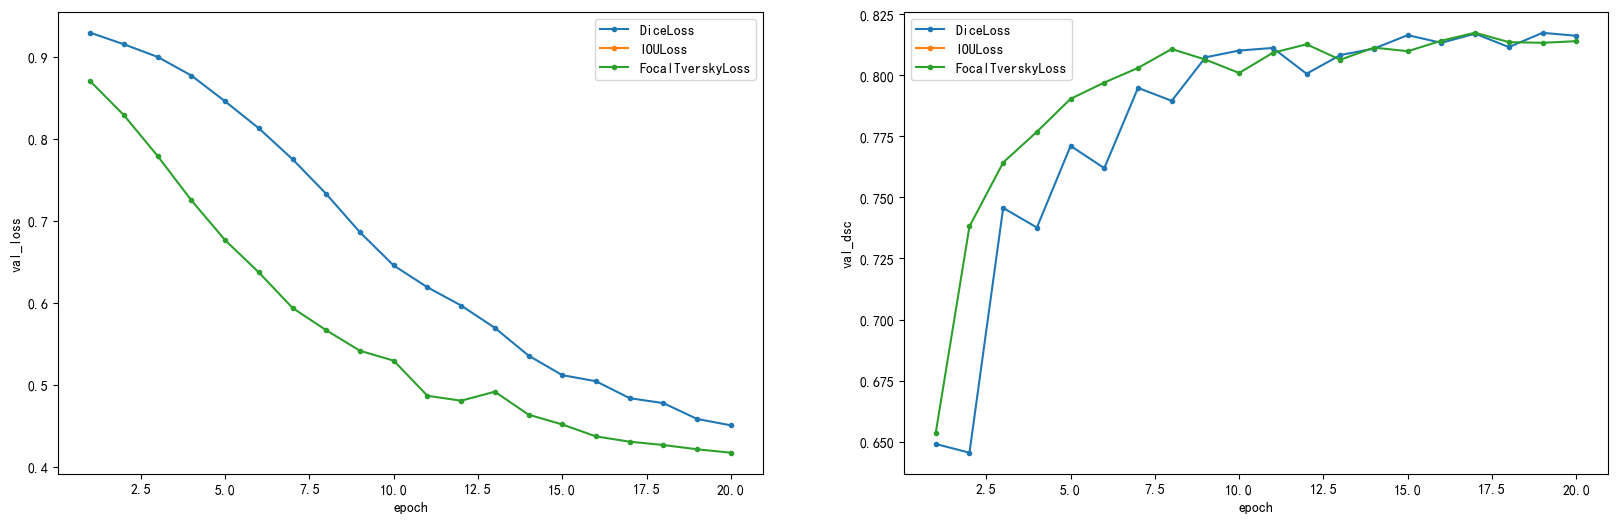

In [13]:
exec_DiceLoss = exec_result.query("loss_function == 'DiceLoss' & optimizer_function == 'Adam' & weight_decay ==0.0002 & use_lr_scheduler ==True")
exec_IOULoss = exec_result.query("loss_function == 'IOULoss' & optimizer_function == 'Adam' & weight_decay ==0.0002 & use_lr_scheduler ==True")
exec_FocalTverskyLoss = exec_result.query("loss_function == 'FocalTverskyLoss' & optimizer_function == 'Adam' & weight_decay ==0.0002 & use_lr_scheduler ==True")

plt.figure(figsize=(20,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.subplot(121)
plt.plot(range(1,len(exec_DiceLoss)+1),exec_DiceLoss['val_loss'], marker='.', label ='DiceLoss')
plt.plot(range(1,len(exec_IOULoss)+1),exec_IOULoss['val_loss'], marker='.', label ='IOULoss')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_loss'], marker='.', label ='FocalTverskyLoss')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,len(exec_DiceLoss)+1),exec_DiceLoss['val_dsc'], marker='.', label ='DiceLoss')
plt.plot(range(1,len(exec_IOULoss)+1),exec_IOULoss['val_dsc'], marker='.', label ='IOULoss')
plt.plot(range(1,len(exec_FocalTverskyLoss)+1),exec_FocalTverskyLoss['val_dsc'], marker='.', label ='FocalTverskyLoss')
plt.xlabel('epoch')
plt.ylabel('val_dsc')
plt.legend()
plt.show()